# Importing needed Python packages
* Numpy for matrix calculations
* Pandas to handle dataframes
* Matplotlib and seaborn for plotting
* Scikit-learn for machine-learning algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

# The dataset: SDSS catalog

The Sloan Digital Sky Survey (http://www.sdss.org/) has surveyed the northern sky with a dedicated 2.5 m diameter telescope at the Apache Point Observatory in New Mexico, USA. The telescope uses mosaic of 30 CCD detectors, each with 2048x2048 pixels. 

The telescope takes images of the sky in 5 different filters (see table below). Each filter correspond to a different color within the visible spectrum. 

| Filter | Center wavelength (nm) | Approximate color |
|:--------:|:--------:|:--------:|
|  u   |  354.3   | Ultraviolet  |
|  g   |  477.0   | Green  |
|  r   |  623.1   | Red  |
|  i   |  762.5   | Near Infrared  |
|  z   |  913.4   | Infrared |

All the images are analyzed and all the astronomical objects detected inside them are catalogued. Astronomers measure the brightness of each individual object in every image where it has been detected and express them in magnitudes: u, g, r, i, z

# 1. Reading and exploring the data

## 1.1 Reading the data and having a first look

We load the data into a pandas dataframe

In [3]:
sdss_df = pd.read_csv('SDSS_20k.csv', skiprows=0)

We can see how the dataset looks like, and how many rows we have

In [4]:
sdss_df.head(10)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237660635997798607,163.973278,45.960987,19.59332,19.47044,19.41898,19.24323,19.14768,3530,301,4,290,8322694285008066560,QSO,1.702919,7392,56992,153
1,1237655123933724801,180.408862,3.813108,17.68916,15.97373,15.15367,14.68167,14.36919,2247,301,1,131,946893956128466944,QSO,0.073511,841,52375,44
2,1237671939822911914,328.968606,45.820257,17.62808,16.22809,15.67356,15.46072,15.33882,6162,301,3,413,2877904957481183232,STAR,-0.000017,2556,54000,381
3,1237671939807903855,275.585578,64.286977,16.81685,15.82498,15.52172,15.38394,15.35682,6162,301,3,184,2873394496509339648,STAR,-0.000900,2552,54632,356
4,1237678860065964720,322.167441,10.062649,19.58341,19.48789,19.08715,18.91311,18.85229,7773,301,5,62,821933086768916480,QSO,1.418552,730,52466,95
5,1237663788486623568,110.544135,41.007407,17.65292,16.13181,15.44886,15.15169,14.99401,4264,301,4,28,3608654968057339904,STAR,-0.000028,3205,54848,530
6,1237663788487409792,111.513340,42.598481,16.73921,15.76221,15.37943,15.21267,15.15262,4264,301,4,40,4119804735258908672,STAR,-0.000501,3659,55181,498
7,1237663788488917132,113.529835,45.750340,18.14476,17.13474,16.79283,16.66507,16.62444,4264,301,4,63,6690291964204832768,STAR,-0.000783,5942,56210,708
8,1237663788491473069,117.434859,50.960033,18.37284,17.41093,17.06018,16.91058,16.87234,4264,301,4,102,4142306790946920448,STAR,-0.000196,3679,55209,440
9,1237663788494880804,124.094677,57.652531,18.26100,17.74013,17.29706,16.96099,16.70477,4264,301,4,154,5797489067743795200,QSO,2.074916,5149,55944,838


In [5]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      20000 non-null  int64  
 1   ra         20000 non-null  float64
 2   dec        20000 non-null  float64
 3   u          20000 non-null  float64
 4   g          20000 non-null  float64
 5   r          20000 non-null  float64
 6   i          20000 non-null  float64
 7   z          20000 non-null  float64
 8   run        20000 non-null  int64  
 9   rerun      20000 non-null  int64  
 10  camcol     20000 non-null  int64  
 11  field      20000 non-null  int64  
 12  specobjid  20000 non-null  uint64 
 13  class      20000 non-null  object 
 14  redshift   20000 non-null  float64
 15  plate      20000 non-null  int64  
 16  mjd        20000 non-null  int64  
 17  fiberid    20000 non-null  int64  
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 2.7+ MB


### Meaning of the different data columns

* General object parameters
   * **Objid** - Object identifier
   * **ra, dec** - Coordinates of the object on the sky
* Parameters from the images
   * **u, g, r, i, z** - Magnitudes in all 5 filters
   * **run, rerun, camcol, field** - coordinates to identify the image where the object was detected, according to the observing strategy followed by SDSS
* Parameters from the spectra
   * **specobjid** - Identifier of the spectrum taken of that object with the spectrograph
   * **class** - Classification after examining the corresponding spectrum
   * **plate, mjd, fiberid** - coordinates to identify the spectra of that object, according to the observing strategy followed by SDSS 

## 1.2 Basic statistics

We want to explore the range of numerical values in each column, and also if we have gaps in any of them.
We also want to have a look at the categories.

In [6]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.00000,20000.00000,20000.000000
mean,1.237663e+18,179.915189,25.169526,18.615253,17.390669,16.873615,16.625298,16.466378,3981.378450,301.0,3.274850,182.655950,3.023124e+18,0.167908,2684.99045,53978.32520,341.005600
std,7.233697e+12,82.743168,20.368557,0.842916,0.985675,1.134230,1.209240,1.270973,1684.233878,0.0,1.699662,142.060164,2.564822e+18,0.454468,2278.00470,1571.34495,220.354775
min,1.237646e+18,0.016392,-17.646052,10.996230,9.989008,9.356278,9.100110,9.612333,109.000000,301.0,1.000000,11.000000,2.996458e+17,-0.004021,266.00000,51608.00000,1.000000
25%,1.237658e+18,135.040528,6.241660,18.165437,16.814673,16.181342,15.863865,15.622850,2830.000000,301.0,2.000000,82.000000,1.386146e+18,-0.000026,1231.00000,52762.00000,155.000000
50%,1.237662e+18,183.362948,26.270190,18.857560,17.501670,16.886375,16.600385,16.433995,3894.000000,301.0,3.000000,148.000000,2.377963e+18,0.038317,2112.00000,53741.00000,325.000000
75%,1.237666e+18,228.579560,40.717897,19.261518,18.046032,17.587398,17.359333,17.247800,4887.000000,301.0,5.000000,239.000000,3.496055e+18,0.091557,3105.00000,54735.00000,503.000000
max,1.237681e+18,359.999615,82.656319,19.599940,19.861680,29.571860,32.141470,28.790550,8162.000000,301.0,6.000000,977.000000,1.412456e+19,7.011245,12545.00000,58930.00000,1000.000000


We have some labels coming from the spectral classification:

* GALAXY
* STAR
* QSO (quasi-stellar object)

The goal of the exercise is to train a model by using these labels, so we can apply it to another dataset where we don't have them (spectra have not been taken).

Let's see how many objects are there from each kind in our dataset (is it balanced among the different categories?)

In [7]:
# How many objects of each kind are there in the dataset?
sdss_df['class'].value_counts()

class
GALAXY    9631
STAR      8289
QSO       2080
Name: count, dtype: int64

## 1.3 More in-depth exploration

Let's make some plots with the data in each column to understand about their distribution, etc.
It will be useful to make plots by separating in different categories, so we can grasp how each property may be similar or diferrent accross types of objects

### Let's start looking at the distribution of redshift for the different classes

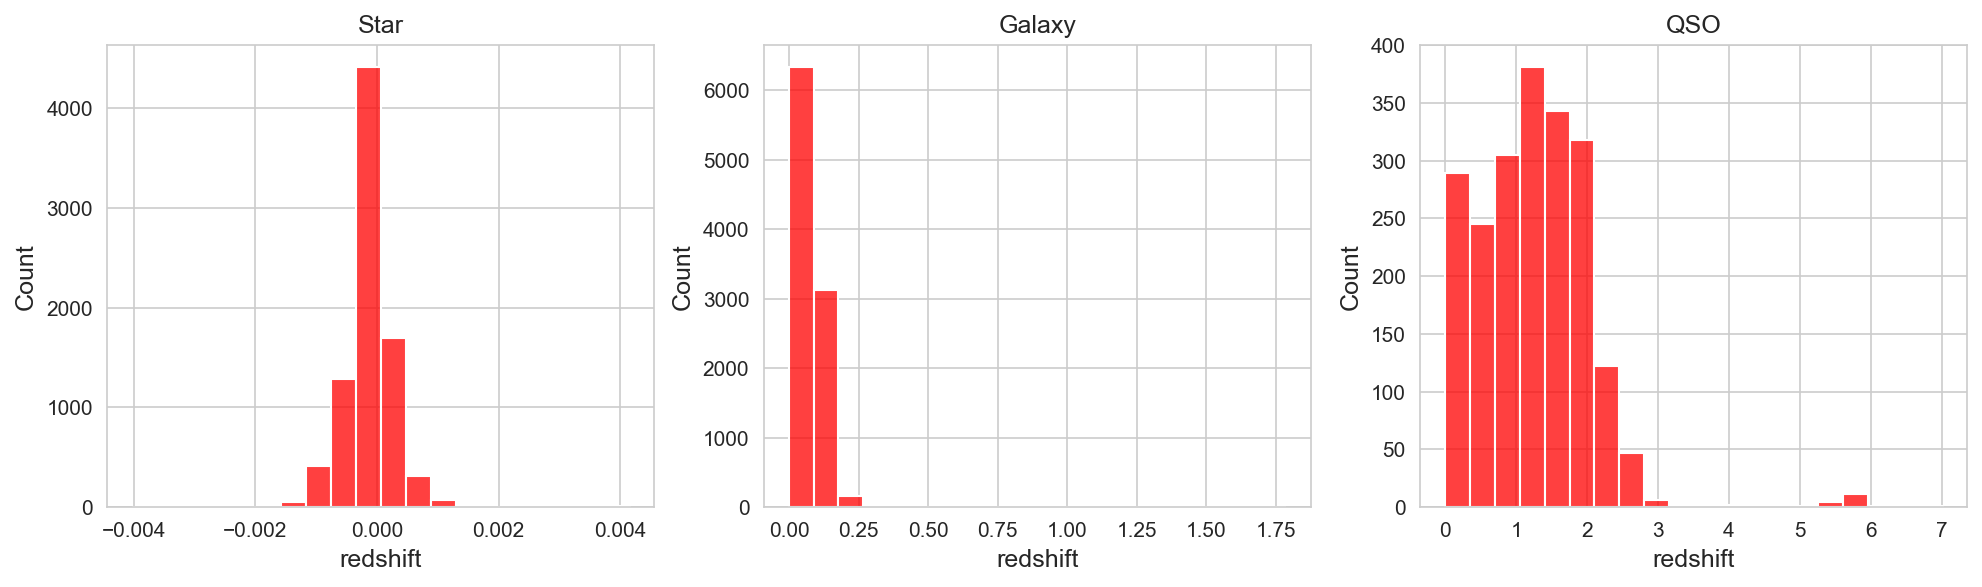

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.histplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 20, ax = axes[0], kde = False, color='red')
ax.set_title('Star')
ax = sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 20, ax = axes[1], kde = False, color='red')
ax.set_title('Galaxy')
ax = sns.histplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 20, ax = axes[2], kde = False, color='red')
ax = ax.set_title('QSO')

### Let's look now at the coordinates on the sky

Text(0.5, 1.0, 'Equatorial coordinates')

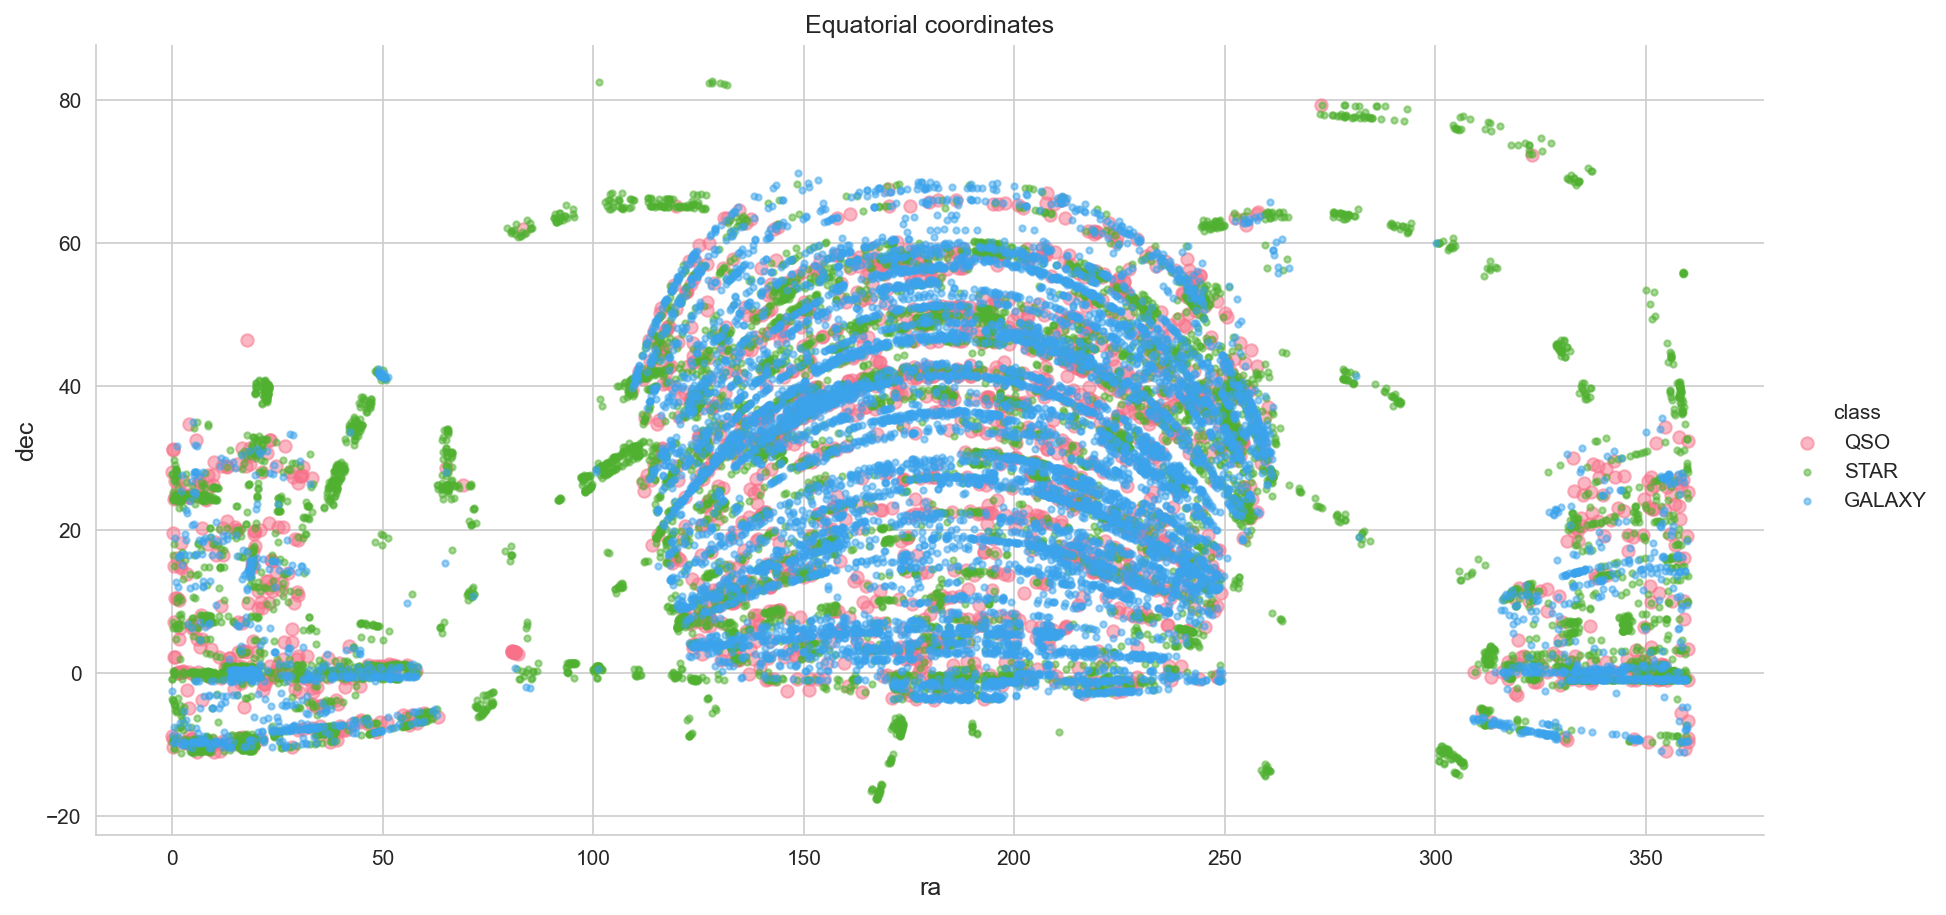

In [9]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='husl', height=6, aspect=2, \
           markers=['o','.','.'], scatter_kws={'alpha':0.5})
plt.title('Equatorial coordinates')

### Box-and-whisker plots can be useful too

The box is centered at the median value and extends from percentile 25 to percentile 75 (interquartile range). The whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers”

Text(0.5, 1.0, 'Declination for all types of objects')

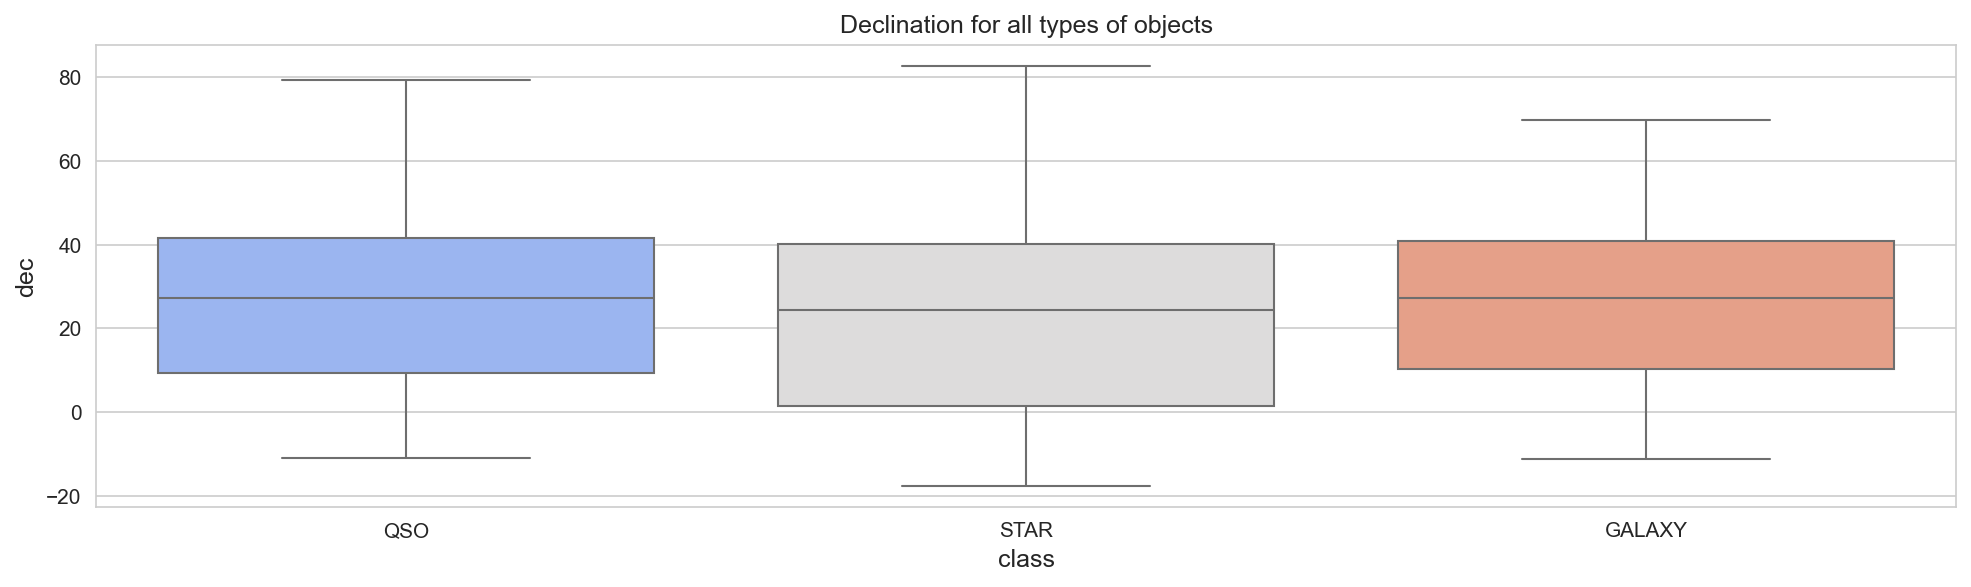

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxplot(x=sdss_df['class'], y=sdss_df['dec'], hue=sdss_df['class'], palette='coolwarm')
ax.set_title('Declination for all types of objects')

Text(0.5, 1.0, 'Right ascension for all types of objects')

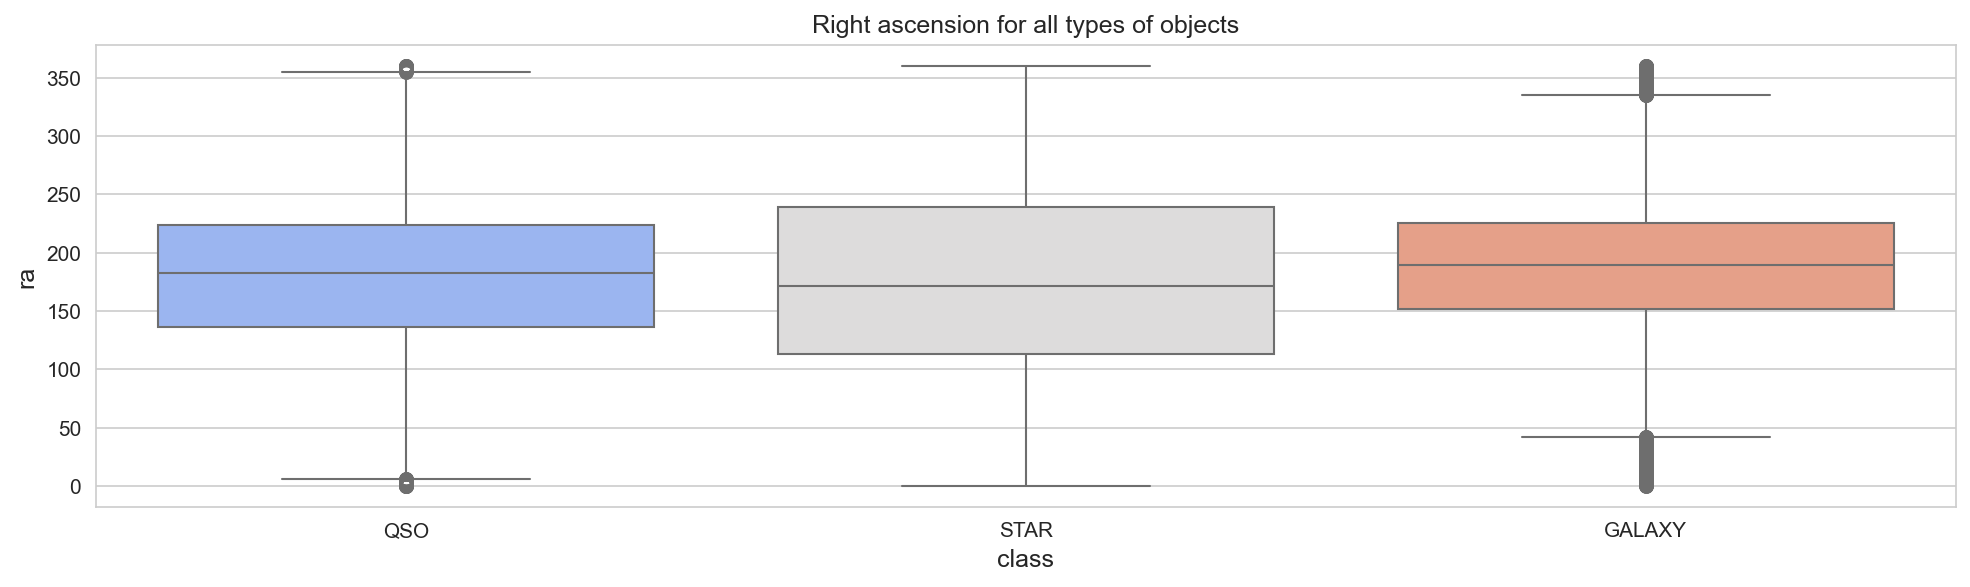

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxplot(x=sdss_df['class'], y=sdss_df['ra'], hue=sdss_df['class'], palette='coolwarm')
ax.set_title('Right ascension for all types of objects')

### Now you look at the magnitudes from the images. It may be useful to split per object category

### Also look at the features related to the image taking process

### Finally look at the features related to the spectra taking process

# 2. Machine Learning Model - Training

<font color="red">Let's create a copy of our dataframe because we will modify it from now on, and we want to keep the original, just in case...</font>

In [12]:
sdss_df_fe = sdss_df.copy(deep=True)

### 2.1 Preparing the data before training the model

* We will remove those features that are not important in the classification.
* We will encode the categories ['STAR', 'GALAXY', 'QSO'] into integer numbers
* We will also scale the numerical values of all features between 0 and 1 so they are all balanced in the fit.

In [13]:
# It is cleat at this point that:
#  objid, specobjid : They are unique indices per object, so they cannot be useful in our model fit
#  rerun is always 301 for all the sample, so it doesn't provide any useful information

sdss_df_fe.drop(['objid','specobjid'], axis=1, inplace=True)

In [14]:
sdss_df_fe

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,class,redshift,plate,mjd,fiberid
0,163.973278,45.960987,19.59332,19.47044,19.41898,19.24323,19.14768,3530,301,4,290,QSO,1.702919,7392,56992,153
1,180.408862,3.813108,17.68916,15.97373,15.15367,14.68167,14.36919,2247,301,1,131,QSO,0.073511,841,52375,44
2,328.968606,45.820257,17.62808,16.22809,15.67356,15.46072,15.33882,6162,301,3,413,STAR,-0.000017,2556,54000,381
3,275.585578,64.286977,16.81685,15.82498,15.52172,15.38394,15.35682,6162,301,3,184,STAR,-0.000900,2552,54632,356
4,322.167441,10.062649,19.58341,19.48789,19.08715,18.91311,18.85229,7773,301,5,62,QSO,1.418552,730,52466,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,156.605330,38.746439,18.62664,16.82200,15.94347,15.56314,15.24247,3647,301,3,121,GALAXY,0.061166,1430,53002,314
19996,156.665799,38.763909,18.74928,16.91125,16.05056,15.64771,15.31695,3647,301,3,121,GALAXY,0.061845,1430,53002,316
19997,156.978729,38.903793,18.95926,17.49687,16.73297,16.34775,16.08545,3647,301,3,123,GALAXY,0.093098,1430,53002,262
19998,157.066589,38.934734,17.85960,16.23604,15.42369,14.99266,14.63197,3647,301,3,124,GALAXY,0.054921,1430,53002,226


In [15]:
# And lets encode the categories into integer numbers, which is required for classifiers to work correctly
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

In [16]:
sdss_df_fe.head(20)

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,class,redshift,plate,mjd,fiberid
0,163.973278,45.960987,19.59332,19.47044,19.41898,19.24323,19.14768,3530,301,4,290,1,1.702919,7392,56992,153
1,180.408862,3.813108,17.68916,15.97373,15.15367,14.68167,14.36919,2247,301,1,131,1,0.073511,841,52375,44
2,328.968606,45.820257,17.62808,16.22809,15.67356,15.46072,15.33882,6162,301,3,413,2,-0.000017,2556,54000,381
3,275.585578,64.286977,16.81685,15.82498,15.52172,15.38394,15.35682,6162,301,3,184,2,-0.000900,2552,54632,356
4,322.167441,10.062649,19.58341,19.48789,19.08715,18.91311,18.85229,7773,301,5,62,1,1.418552,730,52466,95
5,110.544135,41.007407,17.65292,16.13181,15.44886,15.15169,14.99401,4264,301,4,28,2,-0.000028,3205,54848,530
6,111.513340,42.598481,16.73921,15.76221,15.37943,15.21267,15.15262,4264,301,4,40,2,-0.000501,3659,55181,498
7,113.529835,45.750340,18.14476,17.13474,16.79283,16.66507,16.62444,4264,301,4,63,2,-0.000783,5942,56210,708
8,117.434859,50.960033,18.37284,17.41093,17.06018,16.91058,16.87234,4264,301,4,102,2,-0.000196,3679,55209,440
9,124.094677,57.652531,18.26100,17.74013,17.29706,16.96099,16.70477,4264,301,4,154,1,2.074916,5149,55944,838


Numeric data scaling. MinMaxScaler scales each feature to the range between 0 and 1

In [17]:
# The result will be an array of numbers that we will use to train the model.
scaler = MinMaxScaler()

# In order to train the model, we need to separate the features we will use in the training from the (now numerical) labels.
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

In [18]:
# Compare that the new data are scaled
print("Unscaled:",sdss_df_fe.drop('class', axis=1).iloc[0].values)
print("Scaled:",sdss[0])

Unscaled: [1.63973278e+02 4.59609868e+01 1.95933200e+01 1.94704400e+01
 1.94189800e+01 1.92432300e+01 1.91476800e+01 3.53000000e+03
 3.01000000e+02 4.00000000e+00 2.90000000e+02 1.70291900e+00
 7.39200000e+03 5.69920000e+04 1.53000000e+02]
Scaled: [0.45545702 0.6341529  0.99923056 0.96037142 0.49776959 0.4402136
 0.49719674 0.42481063 0.         0.6        0.28881988 0.24331789
 0.58034042 0.73531822 0.15215215]


## 2.2. Now splitting the dataset into a training set and a tests set

We will create a training set (2/3 of the data) and a test set (1/3 of the data).

In [19]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

## 2.3 Model Fit: K Nearest Neighbors

To keep track of the training time, we will measure it before and after the training.

In [20]:
# We use the K-Nearest neighbour classifier available in the scikit-learn
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

knn = KNeighborsClassifier()

# We are using the default k value (k=5). So we consider 5 neighbors to determine the classification.

# Fit the model to the training set and measure the elapsed time
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
knn_train_time = training_end-training_start

# 3. Evaluating the model and measuring performance

## 3.1 Applying the model to the test set

In [21]:
# Apply the model to the test set 
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
knn_prediction_time = prediction_end-prediction_start

# These are the labels predicted by the model for the test set
preds

array([0, 0, 0, ..., 2, 0, 0])

## 3.2 Evaluating the model's performance 

Now we compare the outcome of the model prediction with the labels availabe in the test set. We compute the fraction of succesful classifications.

We also show the times of training/prediction.

In [22]:
# Checking the time spent on training and preditction

print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Time consumed for training: 0.013 seconds
Time consumed for prediction: 0.41283 seconds


In [23]:
# Global Accuracy. How many labels has the model predicted correctly, for all categories together?

acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f%%" % (acc_knn))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 85.70%


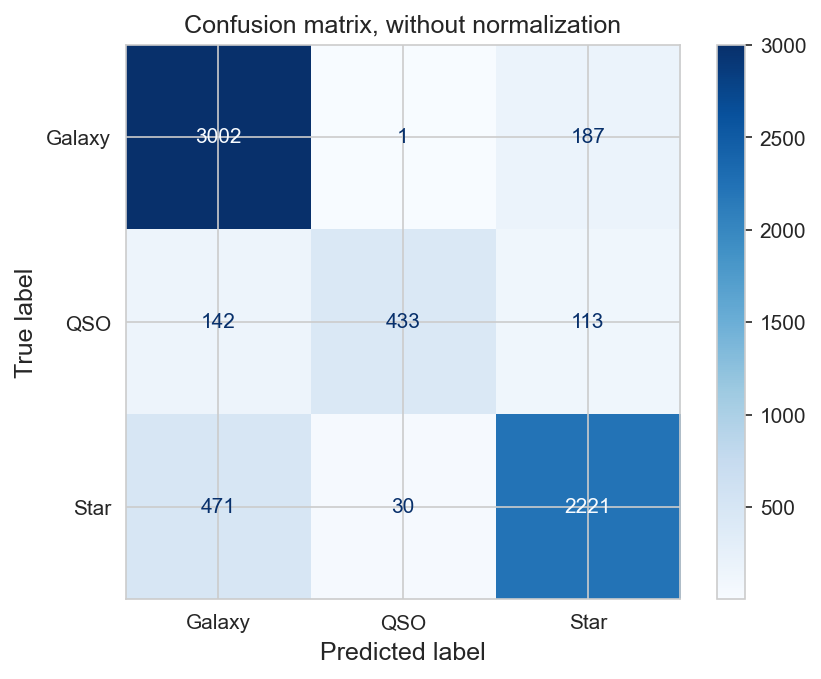

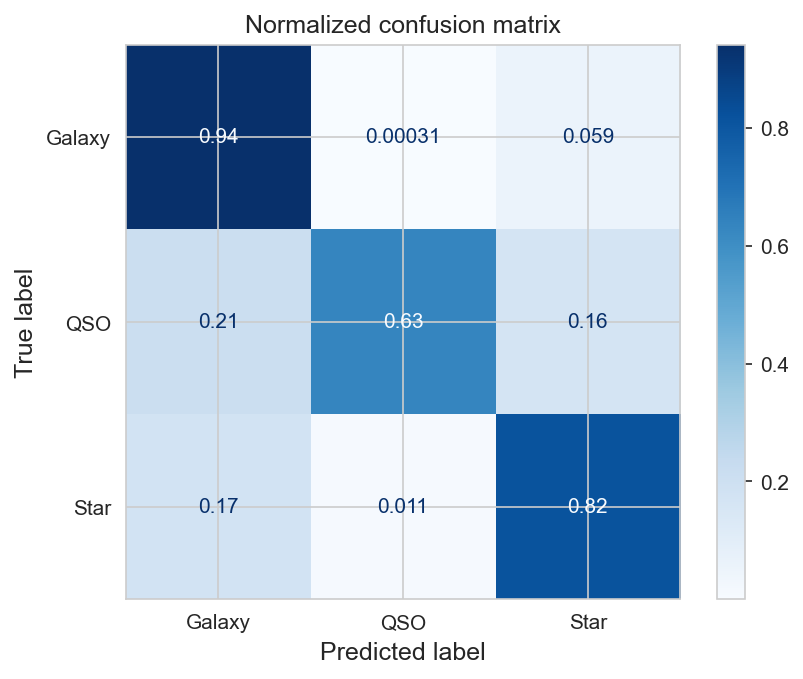

In [24]:
# Confusion matrix. Classification performances per label

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

class_names = ['Galaxy', 'QSO', 'Star']

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        knn,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    disp.figure_.height=2
    disp.figure_.width=2

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

* **Accuracy** is the most common metric to be used in everyday talk. Accuracy answers the question “Out of all the predictions we made, how many were true?”

* **Precision** is a metric that gives you the proportion of true positives to the amount of total positives that the model predicts. It answers the question “Out of all the positive predictions we made, how many were true?”

* **Recall** focuses on how good the model is at finding all the positives. Recall is also called true positive rate and answers the question “Out of all the data points that should be predicted as true, how many did we correctly predict as true?”

* **F1-score** is a measure that combines recall and precision. There is a trade-off between precision and recall, F1 can therefore be used to measure how effectively our models make that trade-off.

In [25]:
print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

      Galaxy       0.83      0.94      0.88      3190
         QSO       0.93      0.63      0.75       688
        Star       0.88      0.82      0.85      2722

    accuracy                           0.86      6600
   macro avg       0.88      0.80      0.83      6600
weighted avg       0.86      0.86      0.85      6600

